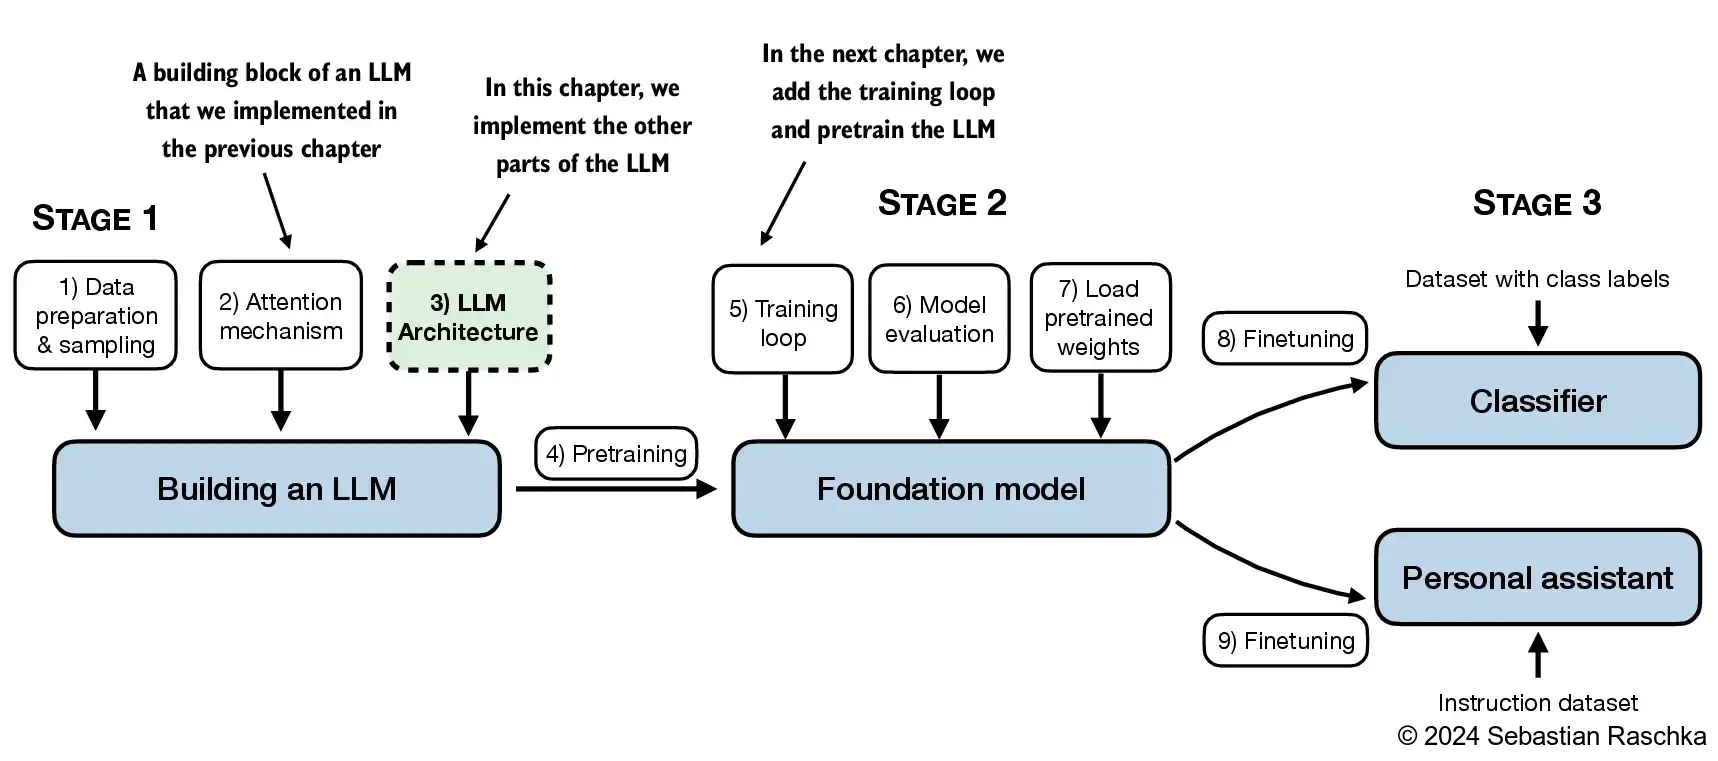

(1) Multi head attention

(2) Layer normalization 

(3) Dropout layer

(4) Feedforward neural network with GELU activation

(5) Shortcut connections

# [Note] Architectures

### pipline

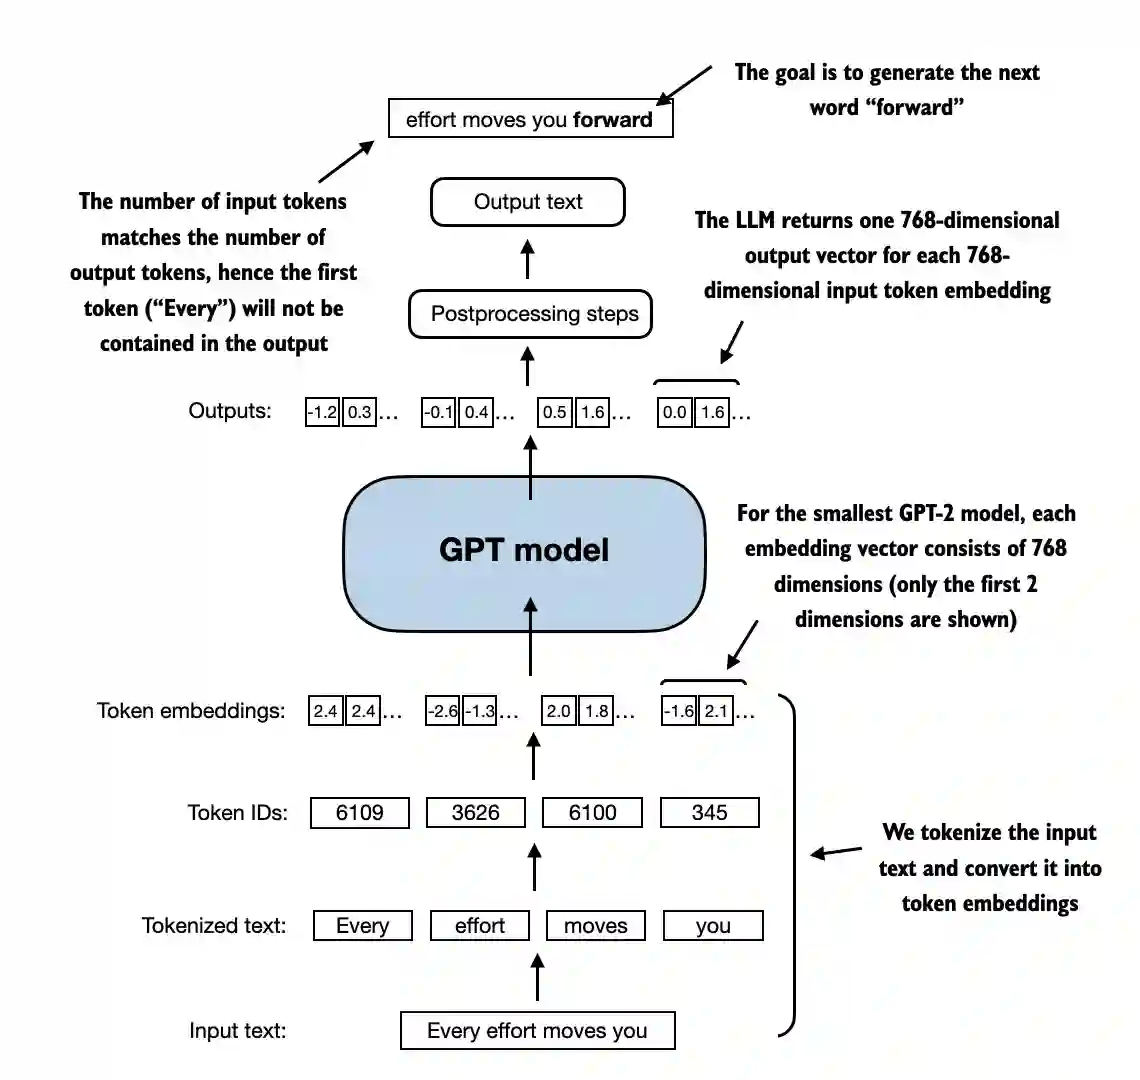

### GPT

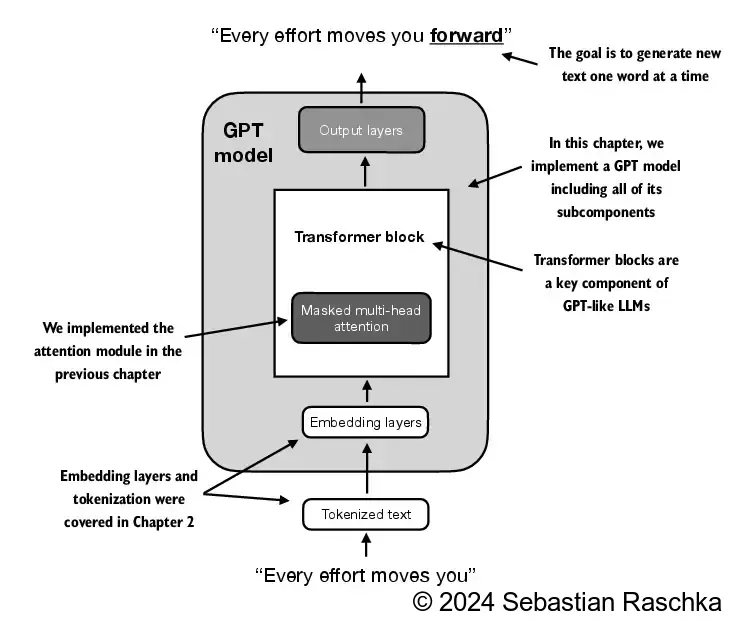

### Transformer

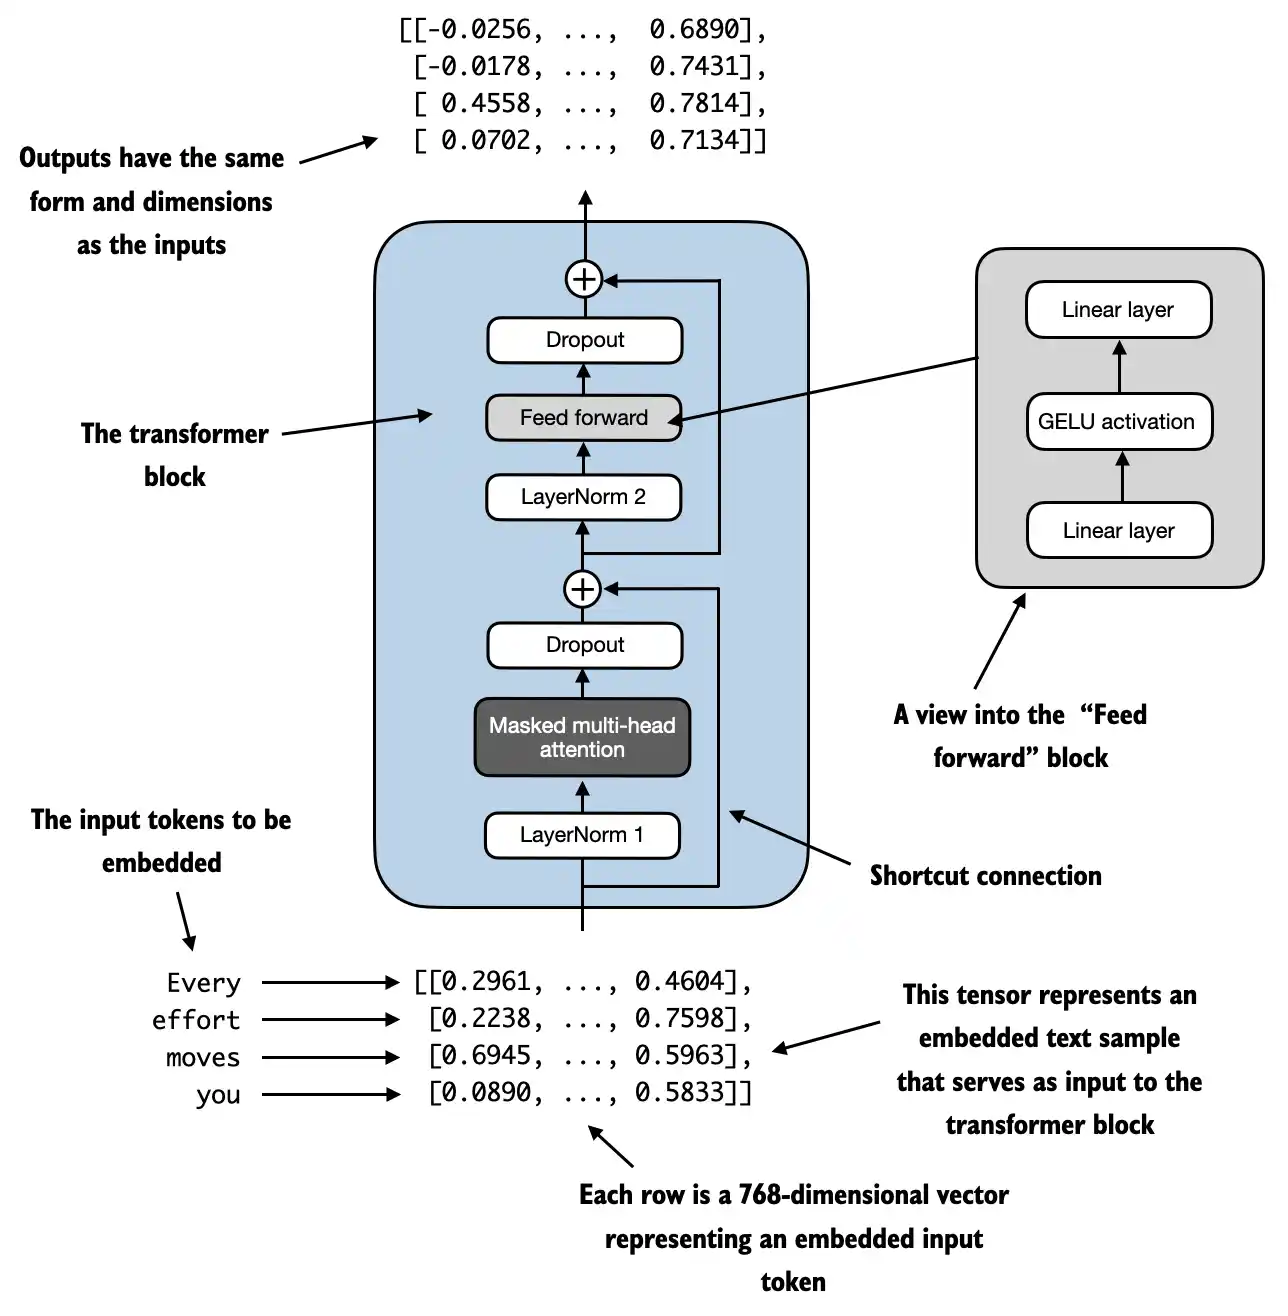

### Masked Multi-head Causal Self-Attention

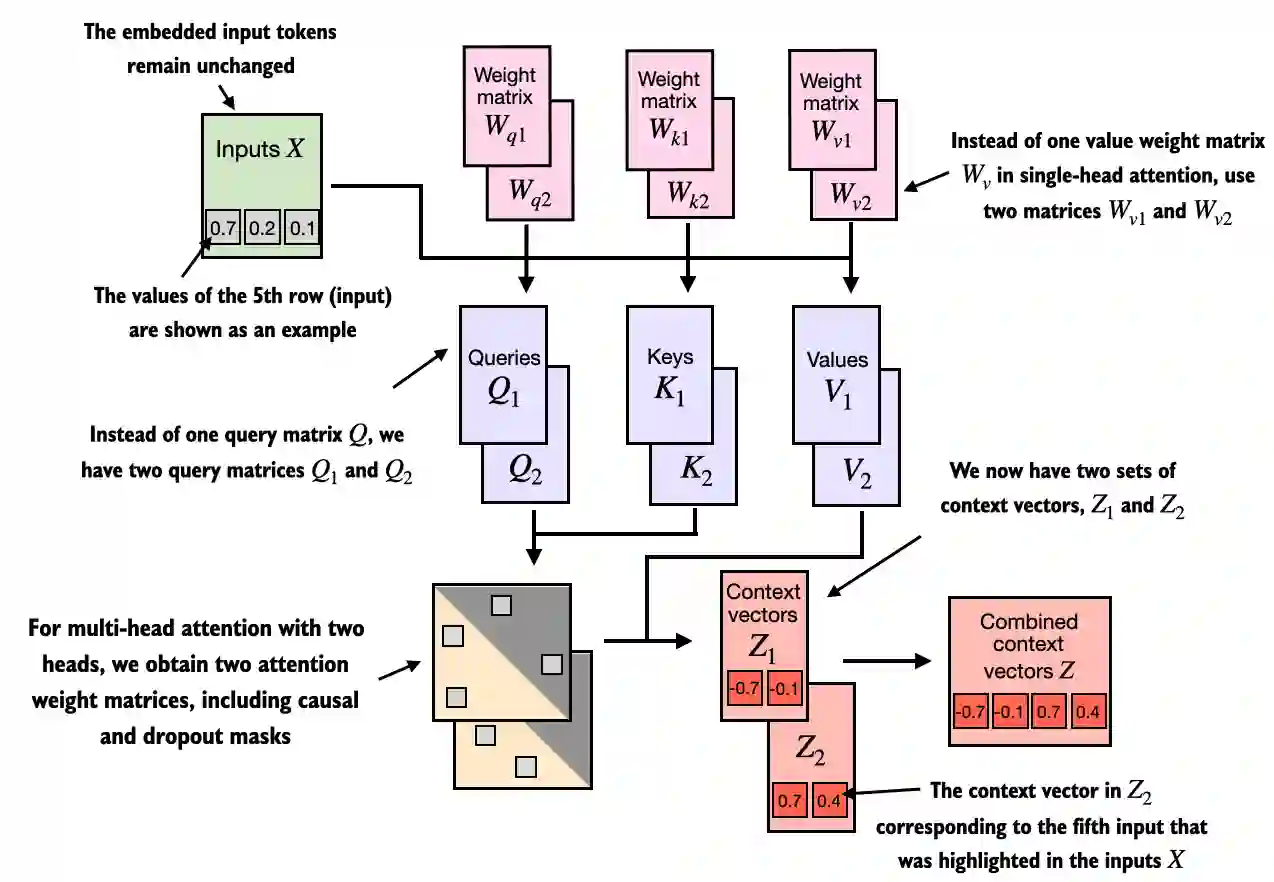

# 0. backbone
**implementing a GPT model from scratch to generate text**

In [23]:
GPT_CONFIG_124M = {
    "vocab_size": 50527,    # 词汇个数
    "context_length": 1024, # sample的长度
    "emb_dim": 768,         # 嵌入维度
    "n_heads": 12,          # 注意力头数
    "n_layers": 12,         # 层数
    "drop_rate": 0.1,       # 权重丢失率
    "qkv_bias": False       # Query-Key-Value偏执设置
}

In [1]:
import torch
import torch.nn as nn


class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        # Use a placeholder for TransformerBlock
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        # Use a placeholder for LayerNorm
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits


class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # A simple placeholder

    def forward(self, x):
        # This block does nothing and just returns its input.
        return x


class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
        # The parameters here are just to mimic the LayerNorm interface.

    def forward(self, x):
        # This layer does nothing and just returns its input.
        return x

In [2]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


# 1. Layer Normalization

作用1：防止梯度消失和爆炸，保持训练稳定

作用2：避免和减少内部协变量（协方差）偏移，加速收敛

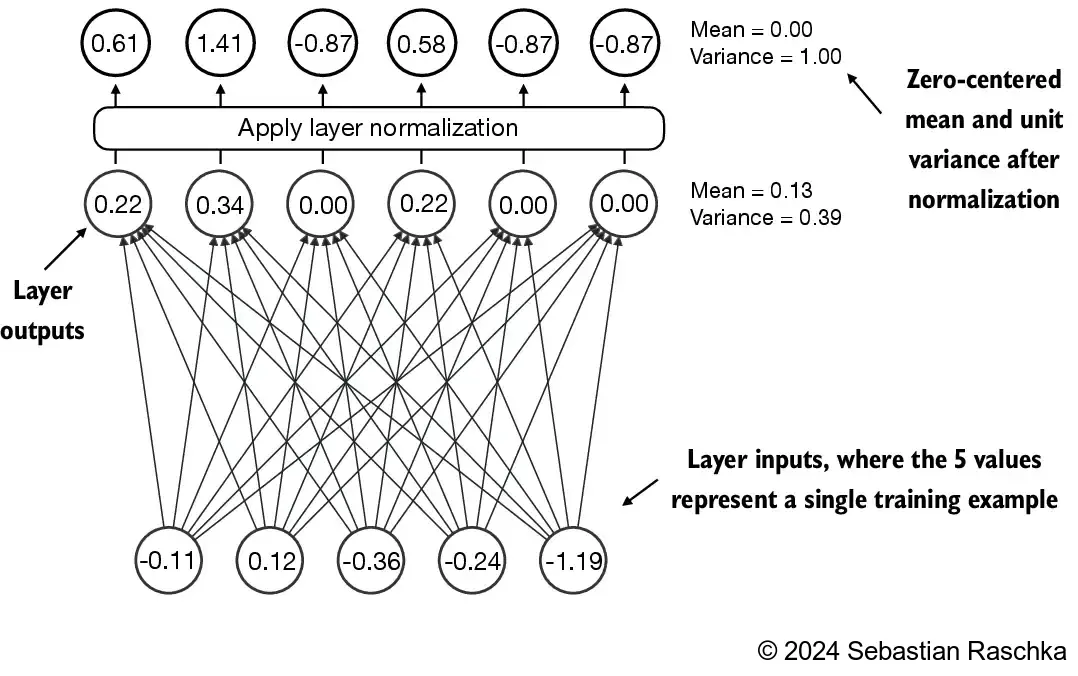

In [3]:
torch.manual_seed(42)
batch_example = torch.rand(2, 5)
layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
print(batch_example)
print(layer[0]) 
print(layer[1])
print(out)

tensor([[0.8823, 0.9150, 0.3829, 0.9593, 0.3904],
        [0.6009, 0.2566, 0.7936, 0.9408, 0.1332]])
Linear(in_features=5, out_features=6, bias=True)
ReLU()
tensor([[0.8085, 0.0080, 0.0357, 0.0000, 0.4141, 0.2423],
        [0.7231, 0.0000, 0.1389, 0.0105, 0.7284, 0.3024]],
       grad_fn=<ReluBackward0>)


In [4]:
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[0.2514],
        [0.3172]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.1012],
        [0.1121]], grad_fn=<VarBackward0>)


In [5]:
out_norm = (out - mean) / torch.sqrt(var)
print("Normalized Lay Outputs:\n", out_norm)

Normalized Lay Outputs:
 tensor([[ 1.7513, -0.7653, -0.6783, -0.7904,  0.5115, -0.0288],
        [ 1.2122, -0.9474, -0.5326, -0.9161,  1.2281, -0.0442]],
       grad_fn=<DivBackward0>)


In [6]:
emb_dim = 6
shift = nn.Parameter(torch.zeros(emb_dim))
print(shift)

class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Patameter(torch.zero(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps) # 防止除0
        return self.scale *  norm_x + self.shift # scale和shift是可训练参数，使模型在处理数据时进行适当的放缩和位移

Parameter containing:
tensor([0., 0., 0., 0., 0., 0.], requires_grad=True)


In [7]:
import torch
import torch.nn as nn


class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        # Use a placeholder for TransformerBlock
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        # Use a placeholder for LayerNorm
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits


class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # A simple placeholder

    def forward(self, x):
        # This block does nothing and just returns its input.
        return x


class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Patameter(torch.zero(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False) # 无偏为True则除数是（n-1）
        norm_x = (x - mean) / torch.sqrt(var + self.eps) # 防止除0
        return self.scale *  norm_x + self.shift # scale和shift是可训练参数，使模型在处理数据时进行适当的放缩和位移

**注意：Batch-Normalization不同与layer-norm，batch-norm是对多个sample的batch的属性即按列进行归一化，而layer-norm是对sample的横向归一化，与batch的大小无关，batch-norm更灵活**

# 2. FeedForward & GELU

In [8]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3))
        ))

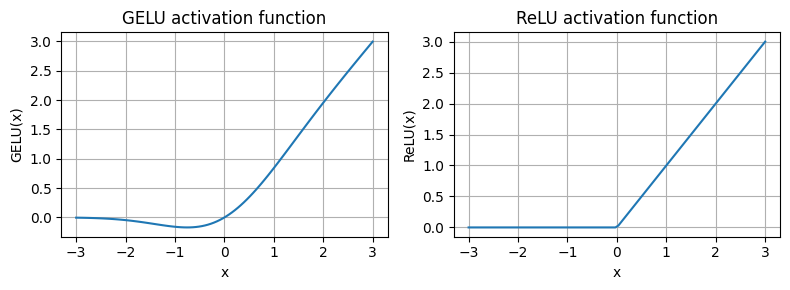

In [9]:
import matplotlib.pyplot as plt

gelu, relu = GELU(), nn.ReLU()

# Some sample data
x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)

plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)

plt.tight_layout()
plt.show()

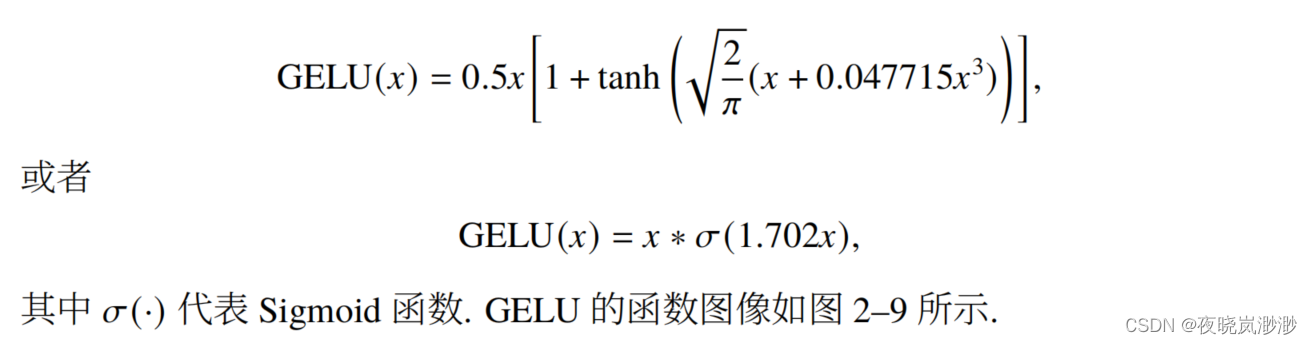

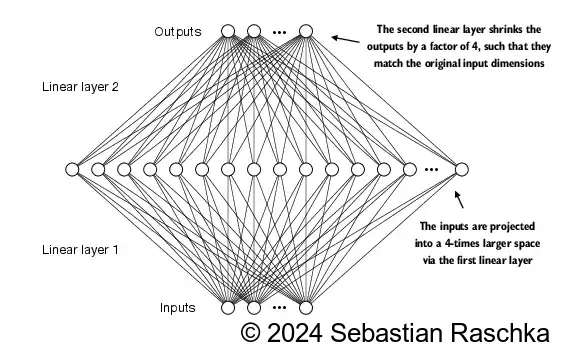

In [10]:
GPT_CONFIG_124M = {
    "vocab_size": 50527,    # 词汇个数
    "context_length": 1024, # sample的长度
    "emb_dim": 768,         # 嵌入维度
    "n_heads": 12,          # 注意力头数
    "n_layers": 12,         # 层数
    "drop_rate": 0.1,       # 权重丢失率
    "qkv_bias": False       # Query-Key-Value偏执设置
}

In [11]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"])
        )
    
    def forward(self, x):
        return self.layers(x)


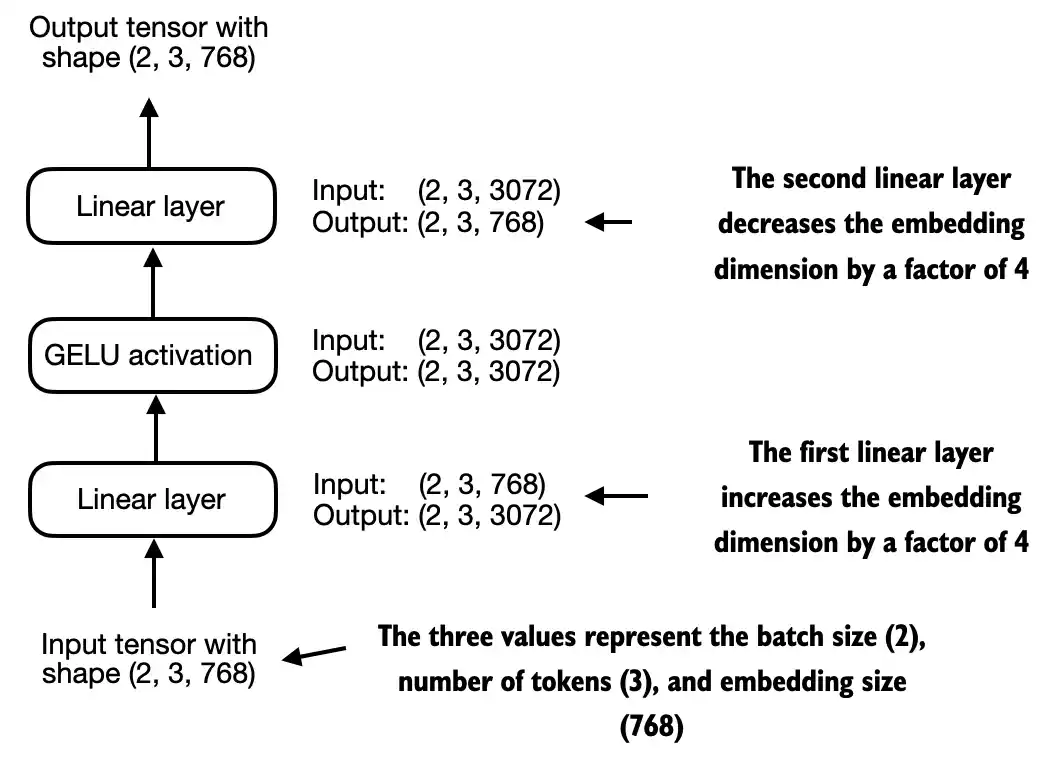

In [12]:
print(GPT_CONFIG_124M['emb_dim'])

768


In [13]:
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2, 3, 768)
output = ffn(x)
print(output.shape)

torch.Size([2, 3, 768])


# 3. Shortcut Connections

解决梯度消失问题

In [14]:
class ExampleDeepNuralNetwork(nn.Module):
    def __init__(self, layer_size, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_size[0], layer_size[1]), GELU()),
            nn.Sequential(nn.Linear(layer_size[1], layer_size[2]), GELU()),
            nn.Sequential(nn.Linear(layer_size[2], layer_size[3]), GELU()),
            nn.Sequential(nn.Linear(layer_size[3], layer_size[4]), GELU()),
            nn.Sequential(nn.Linear(layer_size[4], layer_size[5]), GELU())   
        ])

    def forward(self, x):
        for layer in  self.layers:
            layer_output = layer(x)
            if self.use_shortcut and x.shape == layer_output.shape: # x和W(x)形状一致
                x = x + layer_output
            else:
                x = layer_output
        return x

def print_gradiants(model, x):
    # Forward pass
    output = model(x)
    target = torch.tensor([[0.]])

    loss = nn.MSELoss()
    loss = loss(output, target)

    loss.backward()

    for name, param in model.named_parameters():
        if 'weight' in name:
            # print the mean absolute gradiant of the weights
            print(f"{name} has gradiant mean of {param.grad.abs().mean().item()}")

        # print(f"{name} has gradiant mean of {param.grad.abs().mean().item()}")



In [15]:
layer_size = [3,3,3,3,3,1]

sample_input = torch.tensor([[1., 0., -1.]]) # 两层中括号说明是一个batch
torch.manual_seed(123)
model_without_shortcut = ExampleDeepNuralNetwork(
    layer_size, use_shortcut=False
)

print_gradiants(model_without_shortcut, sample_input)


layers.0.0.weight has gradiant mean of 0.00020173584925942123
layers.1.0.weight has gradiant mean of 0.00012011159560643137
layers.2.0.weight has gradiant mean of 0.0007152040489017963
layers.3.0.weight has gradiant mean of 0.0013988736318424344
layers.4.0.weight has gradiant mean of 0.005049645435065031


/home/wangjz/miniforge3/envs/llm/lib/python3.9/site-packages/torch/autograd/__init__.py:251: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


In [16]:
model_with_shortcut = ExampleDeepNuralNetwork(
    layer_size, use_shortcut=True
)

print_gradiants(model_with_shortcut, sample_input)

layers.0.0.weight has gradiant mean of 0.0014432291500270367
layers.1.0.weight has gradiant mean of 0.004846952389925718
layers.2.0.weight has gradiant mean of 0.004138893447816372
layers.3.0.weight has gradiant mean of 0.005915115587413311
layers.4.0.weight has gradiant mean of 0.032659437507390976


# 4. [mix]Transformer Block
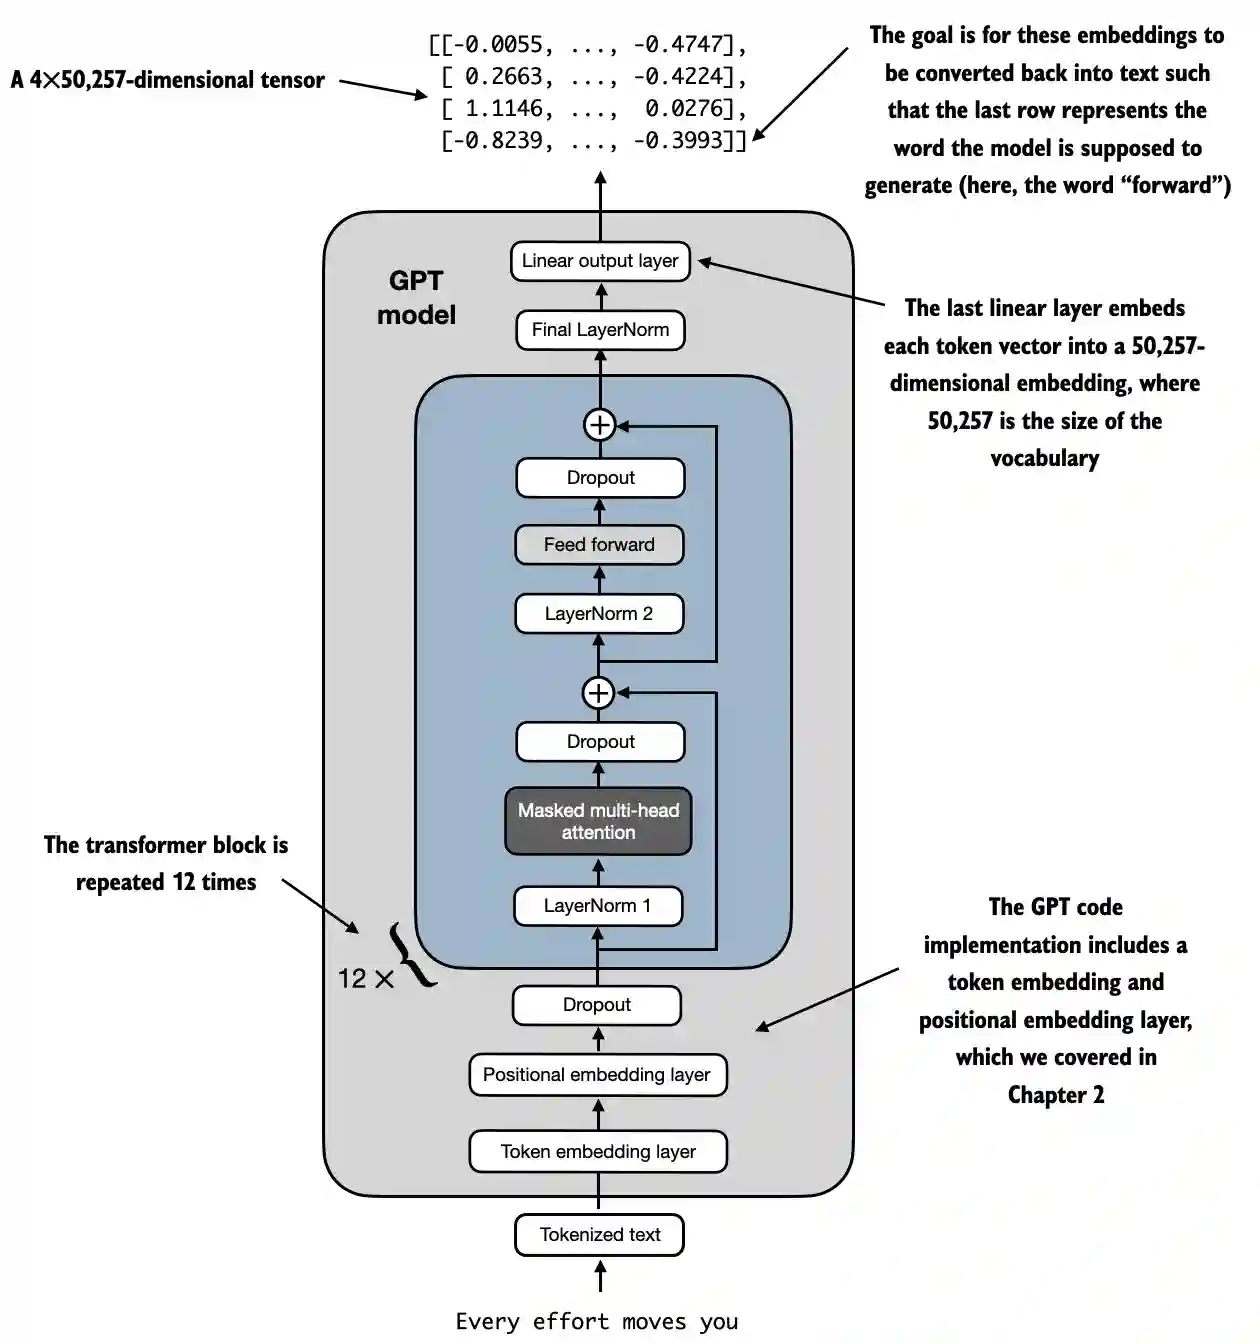

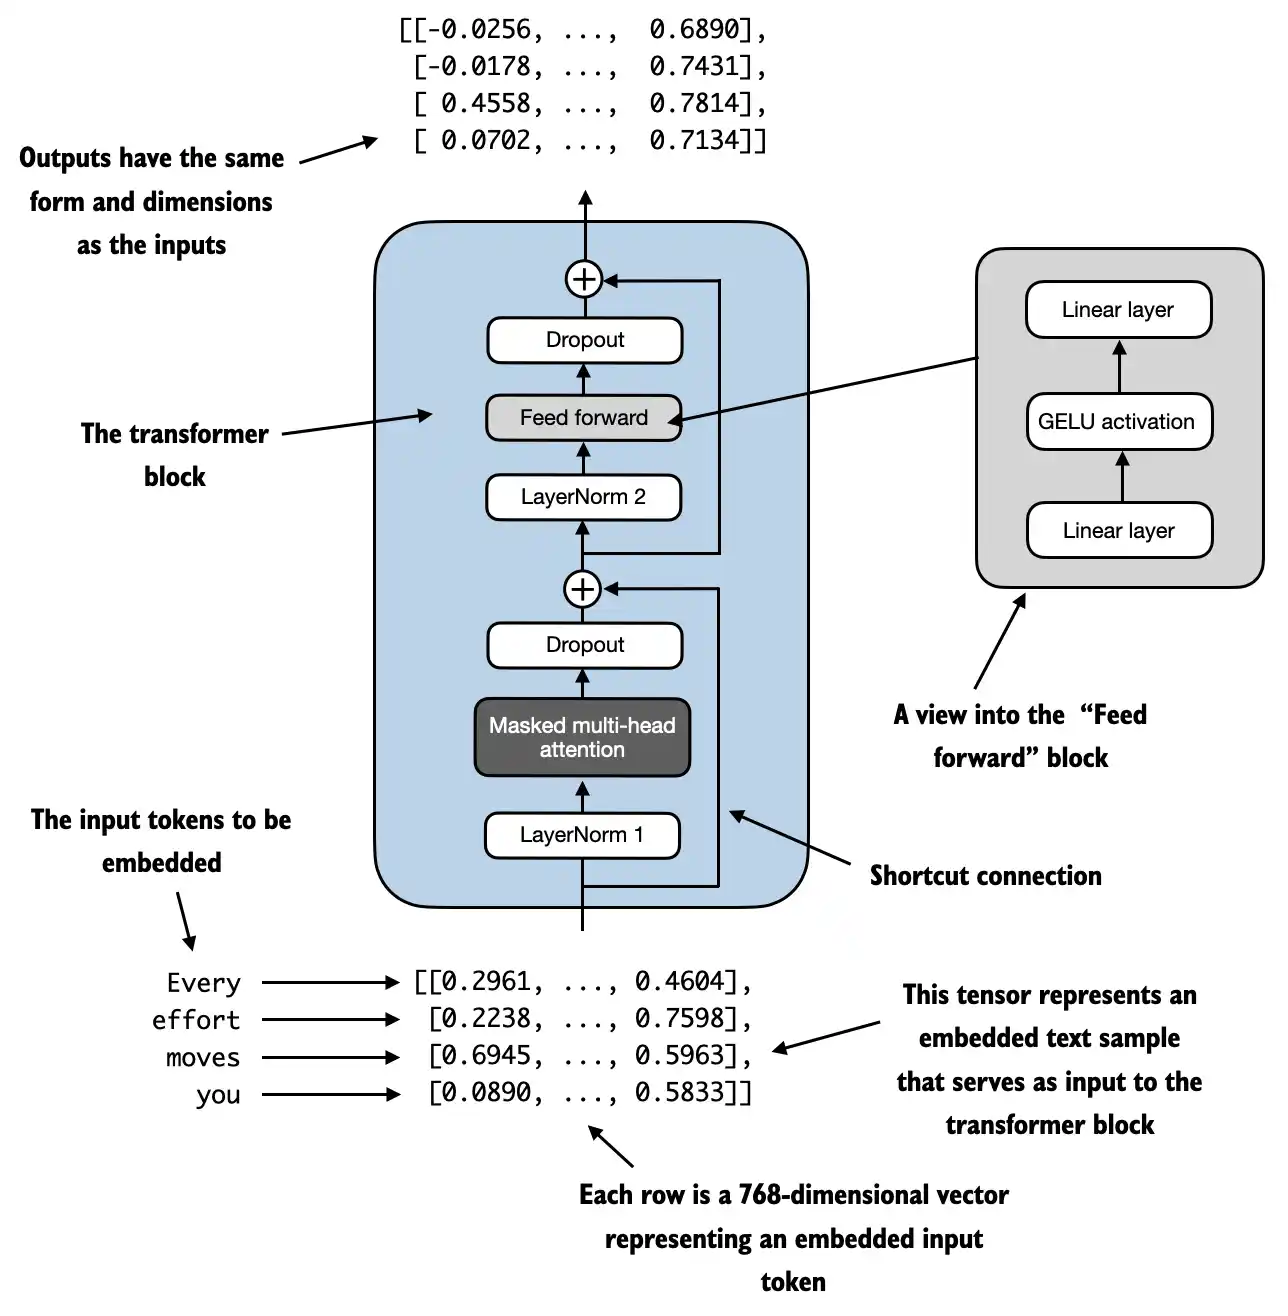

In [17]:
GPT_CONFIG_124M = {
    "vocab_size": 50527,    # 词汇个数
    "context_length": 1024, # sample的长度
    "emb_dim": 768,         # 嵌入维度
    "n_heads": 12,          # 注意力头数
    "n_layers": 12,         # 层数 num of transformers
    "drop_rate": 0.1,       # 权重丢失率
    "qkv_bias": False       # Query-Key-Value偏执设置
}

In [18]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale*norm_x + self.shift
    
class GELU(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.047715 * torch.pow(x, 3))
        ))

class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4*cfg["emb_dim"]),
            GELU(),
            nn.Linear(4*cfg["emb_dim"], cfg['emb_dim'])
        )

    def forward(self, x):
        return self.layers(x)


In [19]:
class MultiheadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_lenght, drop_out, num_heads,  qkv_bias=False):
        super().__init__()
        # 如果条件为假，assert 会抛出一个 AssertionError 异常，并可选地附带一个错误消息。
        assert d_out % num_heads == 0, "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads =num_heads
        self.head_dim = d_out // num_heads

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

        self.out_proj = nn.Linear(d_out, d_out) # 线性层，合并注意力头的输出
        self.dropout = nn.Dropout(drop_out)
        # 上三角矩阵为1
        self.register_buffer('mask', torch.triu(torch.ones(context_lenght, context_lenght), diagonal=1))
    
    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        keys = keys.transpose(1,2) # b,  self.num_heads, num_tokens, self.head_dim
        values = values.transpose(1,2)
        queries = queries.transpose(1,2)

        attn_scores = queries @ values.transpose(2,3) # b,  self.num_heads, self.num_tokens, num_tokens
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1] ** 0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        context_vec = (attn_weights @ values).transpose(1,2) # b, num_tokens, self.num_heads, self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)

        return context_vec



In [20]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiheadAttention(
            d_in=cfg["emb_dim"],
            d_out= cfg["emb_dim"],
            context_lenght=cfg["context_length"],
            drop_out=cfg["drop_rate"],
            num_heads=cfg["n_heads"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg['drop_rate'])

    def forward(self, x):
        short_cut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + short_cut

        short_cut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = short_cut + x

        return x


In [21]:
torch.manual_seed(123)
x = torch.rand(2,4,768)
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)
print("Input shape:", x.shape)
print(x)
print("Output shape:", output.shape)
print(output)

Input shape: torch.Size([2, 4, 768])
tensor([[[0.2961, 0.5166, 0.2517,  ..., 0.9541, 0.8567, 0.4604],
         [0.2238, 0.3047, 0.3019,  ..., 0.5465, 0.4532, 0.7598],
         [0.6945, 0.2478, 0.4111,  ..., 0.8838, 0.4898, 0.5963],
         [0.0890, 0.7804, 0.9223,  ..., 0.4507, 0.6357, 0.5833]],

        [[0.5716, 0.9297, 0.3396,  ..., 0.0477, 0.4564, 0.2797],
         [0.0936, 0.2211, 0.3806,  ..., 0.3948, 0.4545, 0.4536],
         [0.6788, 0.1741, 0.2084,  ..., 0.5557, 0.5930, 0.0959],
         [0.3894, 0.4083, 0.0662,  ..., 0.9861, 0.9341, 0.1319]]])
Output shape: torch.Size([2, 4, 768])
tensor([[[ 0.2365,  0.7771, -0.5190,  ...,  0.7951,  0.7849,  0.2040],
         [ 0.0719,  0.4462, -0.4613,  ...,  0.7645,  0.1331,  0.9336],
         [ 0.9594,  0.7972, -0.1234,  ...,  0.9459,  0.5606,  0.6013],
         [-0.0124,  1.1414,  0.6982,  ...,  0.2384,  0.4654,  1.0144]],

        [[ 0.7762,  1.6303,  2.1257,  ...,  1.5056,  0.2385,  0.1518],
         [-0.0074,  0.2509,  1.0002,  ...,  

# 5. GPT

In [ ]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False # 类onthot code
        )

    '''
    tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])
    '''
    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x) 
        return logits


In [ ]:
tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
out = model(batch)
print("Input batch:\n", batch)
print("\nOutput sha  pe", out.shape)
print(out)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])
Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape torch.Size([2, 4, 50527])
tensor([[[ 1.2286, -0.3959, -0.1360,  ...,  0.4516,  0.4611,  0.1803],
         [ 0.9558, -0.1991,  0.1199,  ...,  0.5778,  0.4383, -0.5998],
         [ 0.8719, -0.2199,  0.1872,  ...,  0.3991, -0.2405, -0.1008],
         [ 1.1249, -0.1974, -0.2718,  ...,  0.6697, -0.0430, -0.0855]],

        [[ 0.2277, -0.2314,  0.3721,  ..., -0.1181,  0.2620,  0.6829],
         [ 1.3796, -0.2184, -0.0752,  ...,  0.1282,  0.3064,  0.3716],
         [ 0.5419, -0.2576, -0.1358,  ...,  0.5518,  0.1576,  0.6864],
         [ 1.0903,  0.0109, -0.6643,  ...,  0.9419, -0.1355,  0.2904]]],
       grad_fn=<UnsafeViewBackward0>)


In [33]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 163,424,256


In [34]:
print("Token embedding layer shape:", model.tok_emb.weight.shape)
print("Output layer shape:", model.out_head.weight.shape)

Token embedding layer shape: torch.Size([50527, 768])
Output layer shape: torch.Size([50527, 768])


In [ ]:
# Calculate the total size in bytes (assuming float32, 4 bytes per parameter)
total_size_bytes = total_params * 4

# Convert to megabytes
total_size_mb = total_size_bytes / (1024 * 1024) # 2**20

print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 623.41 MB


# Predict next word
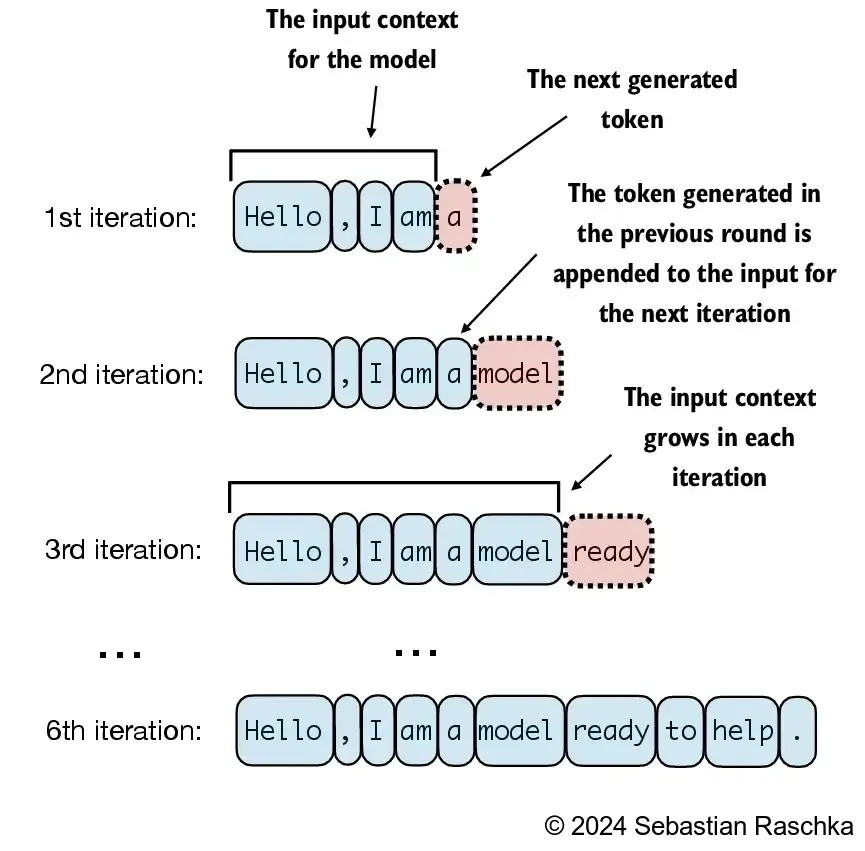

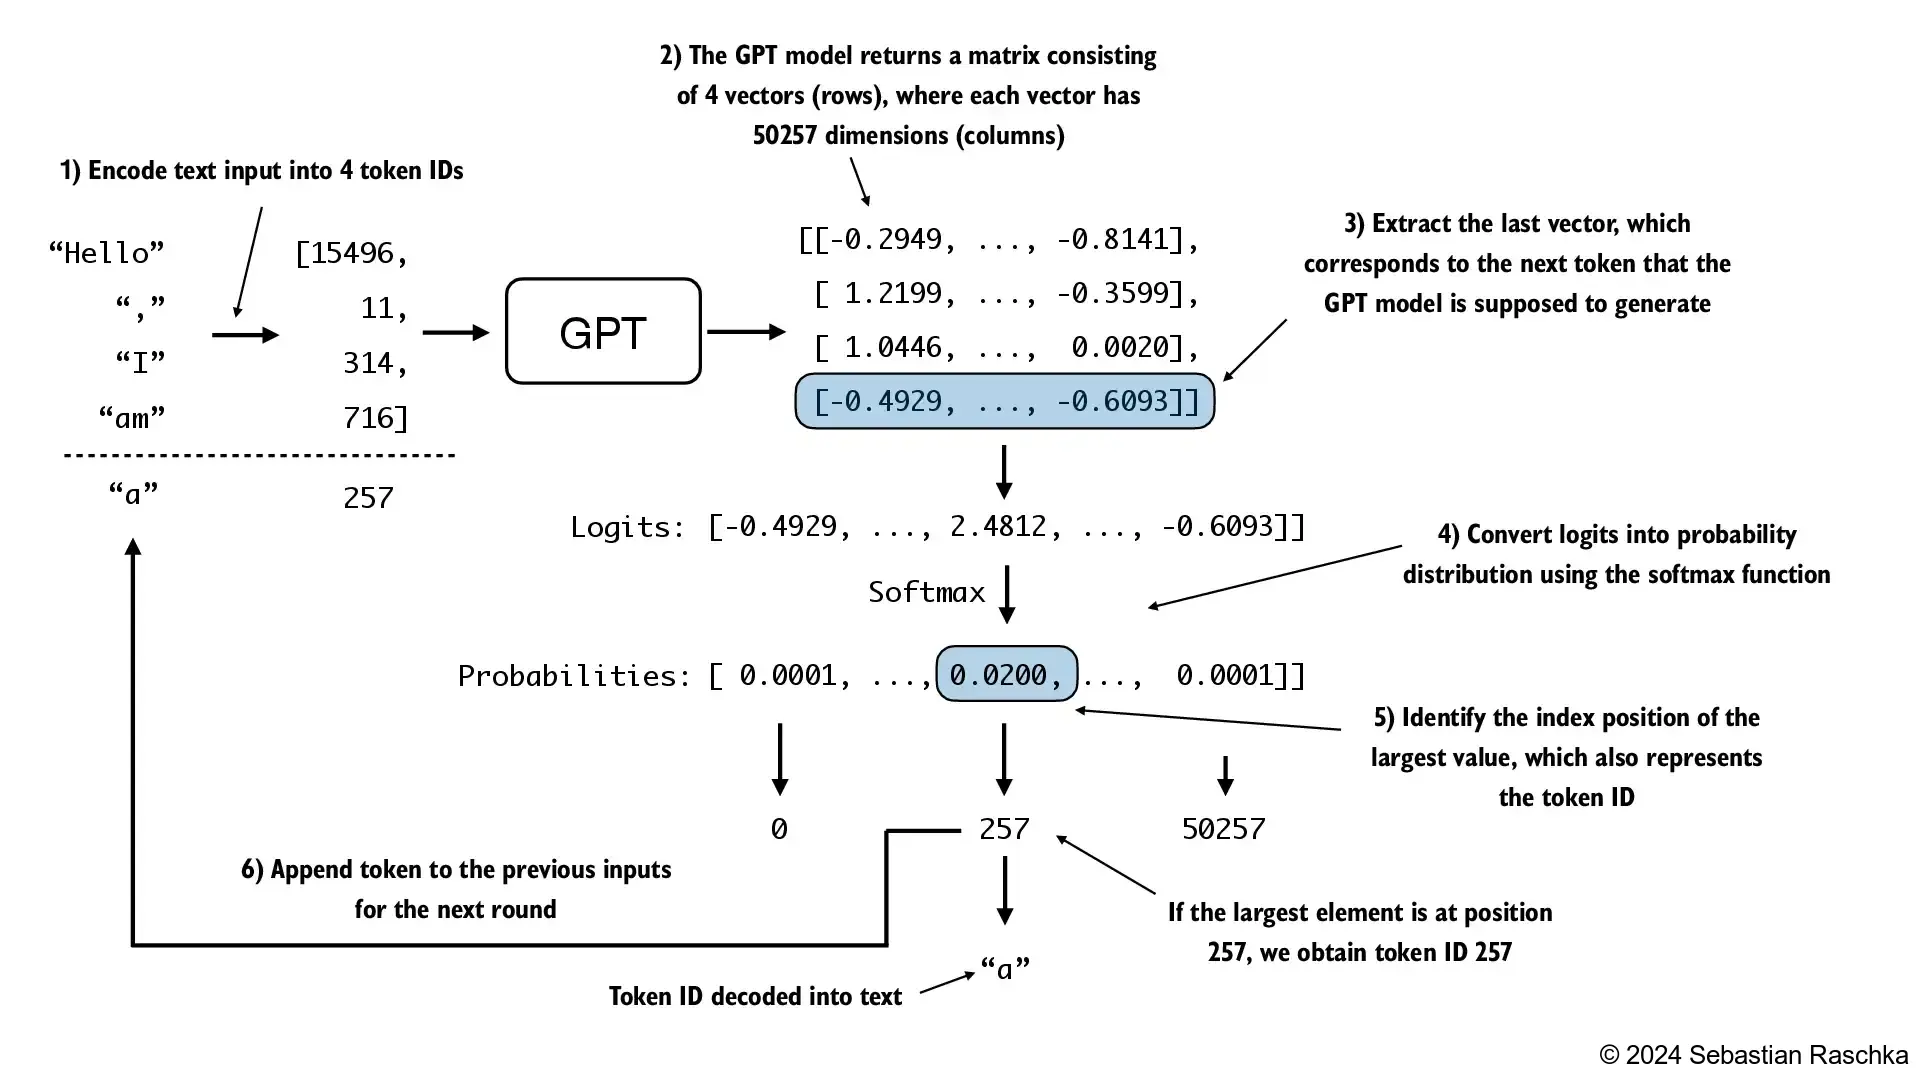

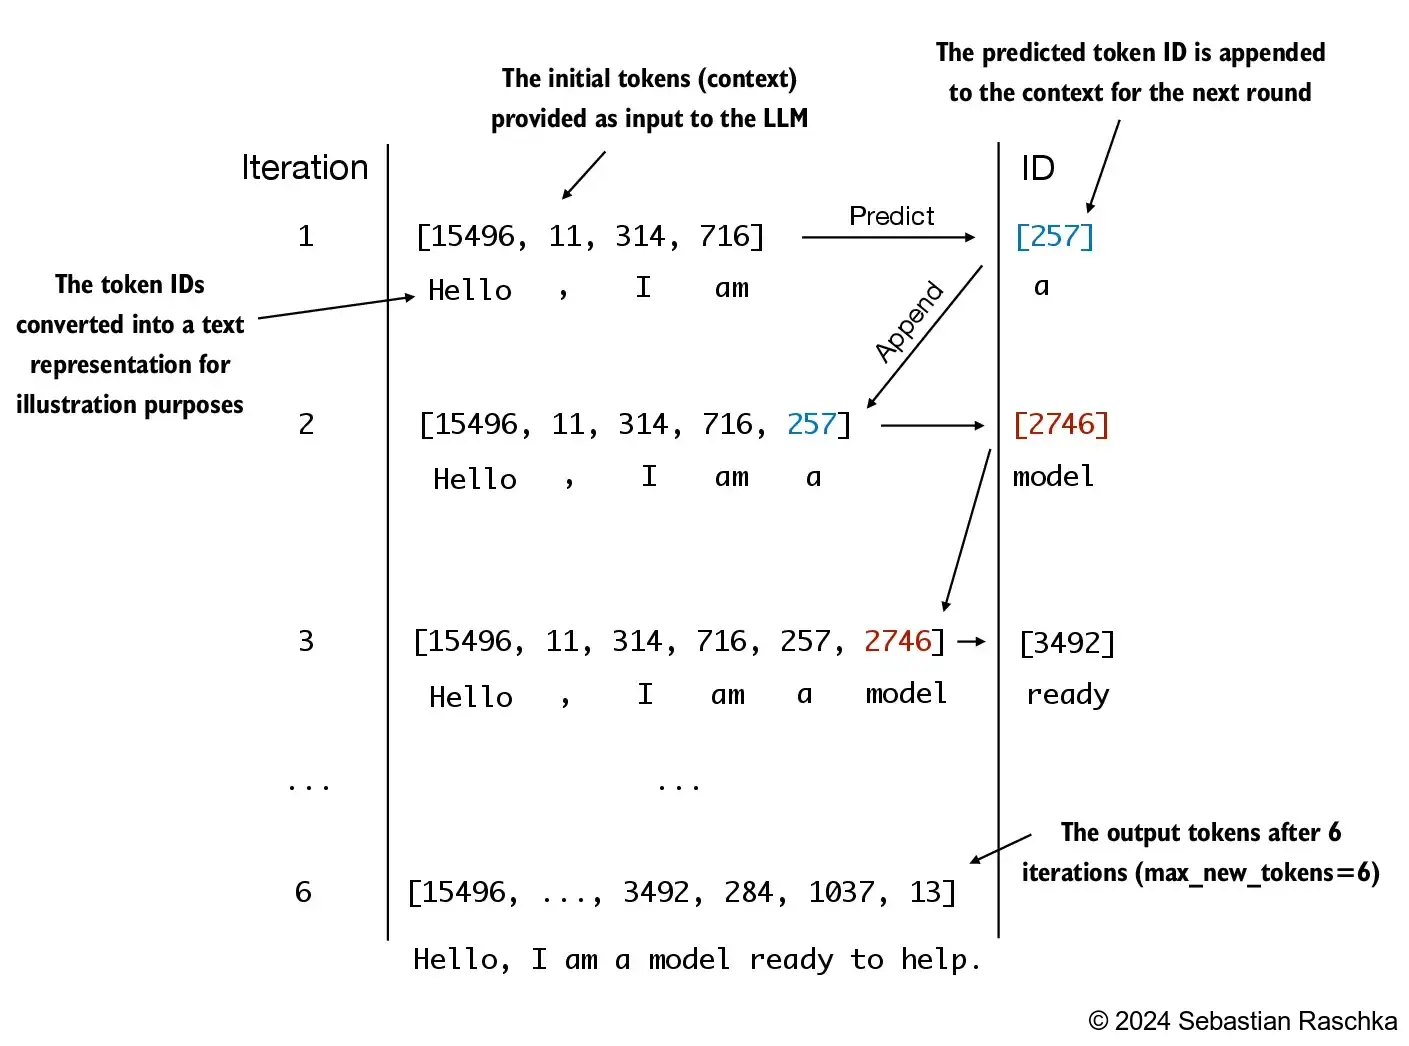

In [37]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (batch, n_tokens) array of indices in the current context
    for _ in range(max_new_tokens):
        
        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:] 
        
        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond)    ### batch, n_tokens, vocab_size
        
        # Focus only on the last time step
        # (batch, n_tokens, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]  

        # Apply softmax to get probabilities
        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)

        # Get the idx of the vocab entry with the highest probability value
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx

In [39]:
start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
print("encoded:", encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape:", encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


In [ ]:

model.eval() # disable dropout

out = generate_text_simple(
    model=model,
    idx=encoded_tensor, 
    max_new_tokens=6, # 生成了6个token
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output:", out)
print("Output length:", len(out[0]))

Output: tensor([[15496,    11,   314,   716, 19585,  7298, 24952, 33902, 31201, 46644]])
Output length: 10


In [41]:
decode_text = tokenizer.decode(out.squeeze(0).tolist())
print(decode_text)


Hello, I amJoe Camkeepers McGuotechnology eclectic
